# Live Daten Montag bis Sonntag

In [1]:
from __future__ import unicode_literals
from IPython.display import display, HTML
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sys
import datetime
import common.live

In [2]:
#config
reload(sys)
sys.setdefaultencoding('utf-8')
plt.rcParams.update({'figure.max_open_warning': 0})
matplotlib.style.use('ggplot')
%matplotlib inline

#constants
LIVE_DATA_DIRECTORY = '/home/marcel/rbtv/rbtvdata/live'

In [3]:
#load live data
live = common.live.load(LIVE_DATA_DIRECTORY)

#create additional column
live['day'] = live.index.strftime('%Y-%m-%d')
live['weekday'] = live.index.dayofweek

## Auswertung 
___

,18:00 - 18:59,19:00 - 19:59,20:00 - 20:59,21:00 - 21:59,22:00 - 22:59
day,,,,,
2016-09-05,7122.133333,6930.750000,5207.200000,3702.766667,2384.066667
2016-09-12,4987.250000,5979.150000,6805.200000,6432.383333,5256.200000
2016-09-19,5368.883333,6474.450000,7368.466667,7057.700000,6817.966667
2016-09-26,5481.233333,5904.416667,6865.550000,6219.033333,5112.000000
2016-10-03,2591.966667,2712.216667,2781.666667,2779.916667,2535.450000
2016-10-10,4894.600000,5731.950000,5173.583333,4152.916667,4449.266667
2016-10-17,4828.066667,5776.516667,6160.250000,5589.050000,5174.650000
2016-10-24,4685.316667,5232.633333,6312.333333,6128.383333,5650.350000
2016-10-31,4828.400000,5262.550000,5305.850000,5336.433333,6601.433333


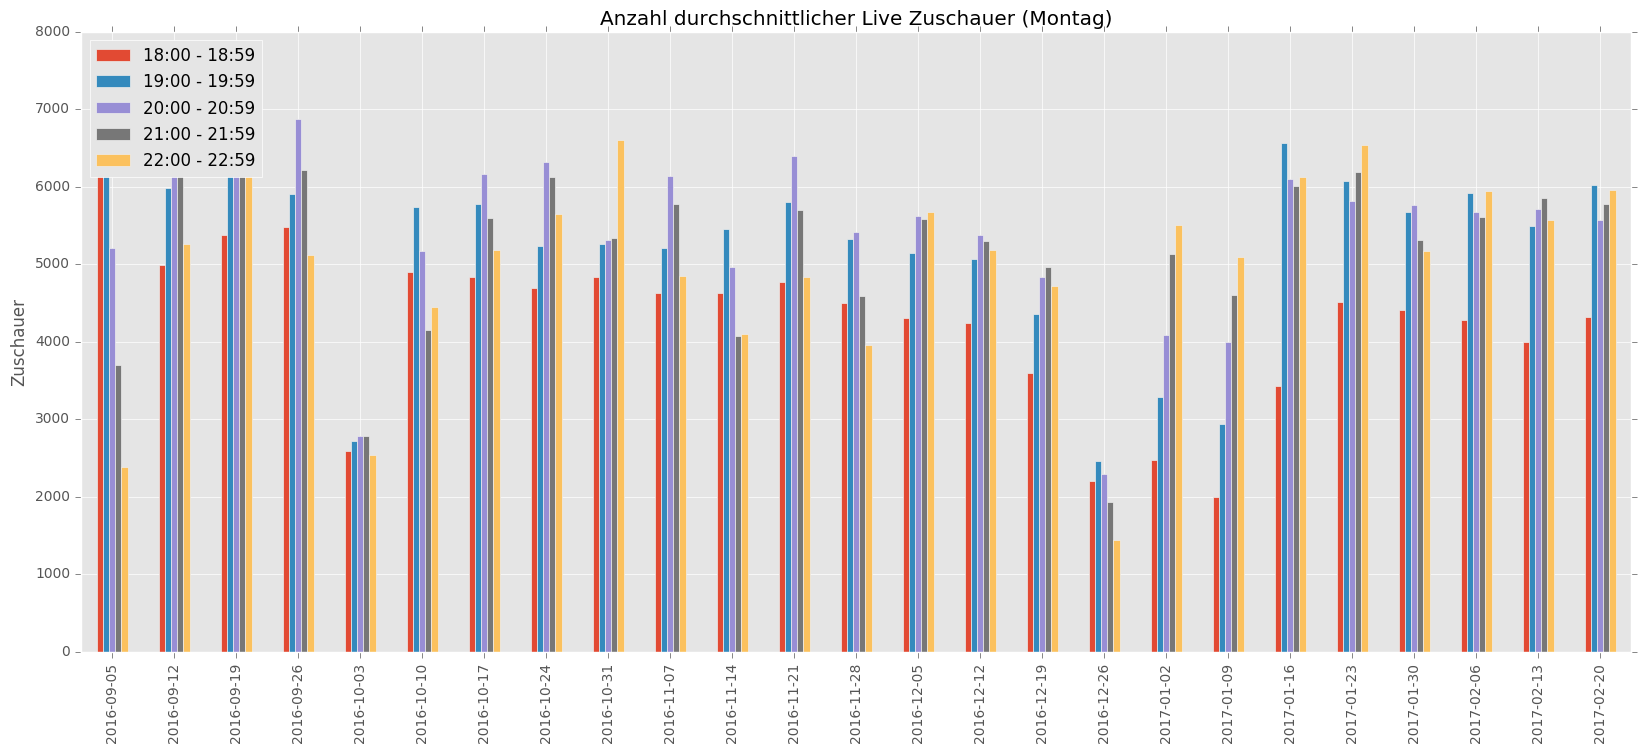

,18:00 - 18:59,19:00 - 19:59,20:00 - 20:59,21:00 - 21:59,22:00 - 22:59
day,,,,,
2016-09-06,9882.283333,10329.700000,5780.733333,3654.250000,2297.983333
2016-09-13,4794.050000,5751.333333,8226.883333,8539.750000,5409.683333
2016-09-20,4887.250000,5532.633333,7497.500000,7419.116667,5402.566667
2016-09-27,4984.200000,5936.200000,9226.683333,8143.516667,4299.550000
2016-10-04,4270.466667,5327.333333,7992.900000,8604.433333,5897.316667
2016-10-11,5274.366667,5838.650000,7276.400000,7073.983333,6555.033333
2016-10-18,4705.916667,5585.966667,7170.450000,6887.416667,3955.933333
2016-10-25,4793.400000,6104.450000,9127.050000,9824.933333,7410.500000
2016-11-01,4842.533333,5689.166667,7532.166667,7733.400000,4551.333333


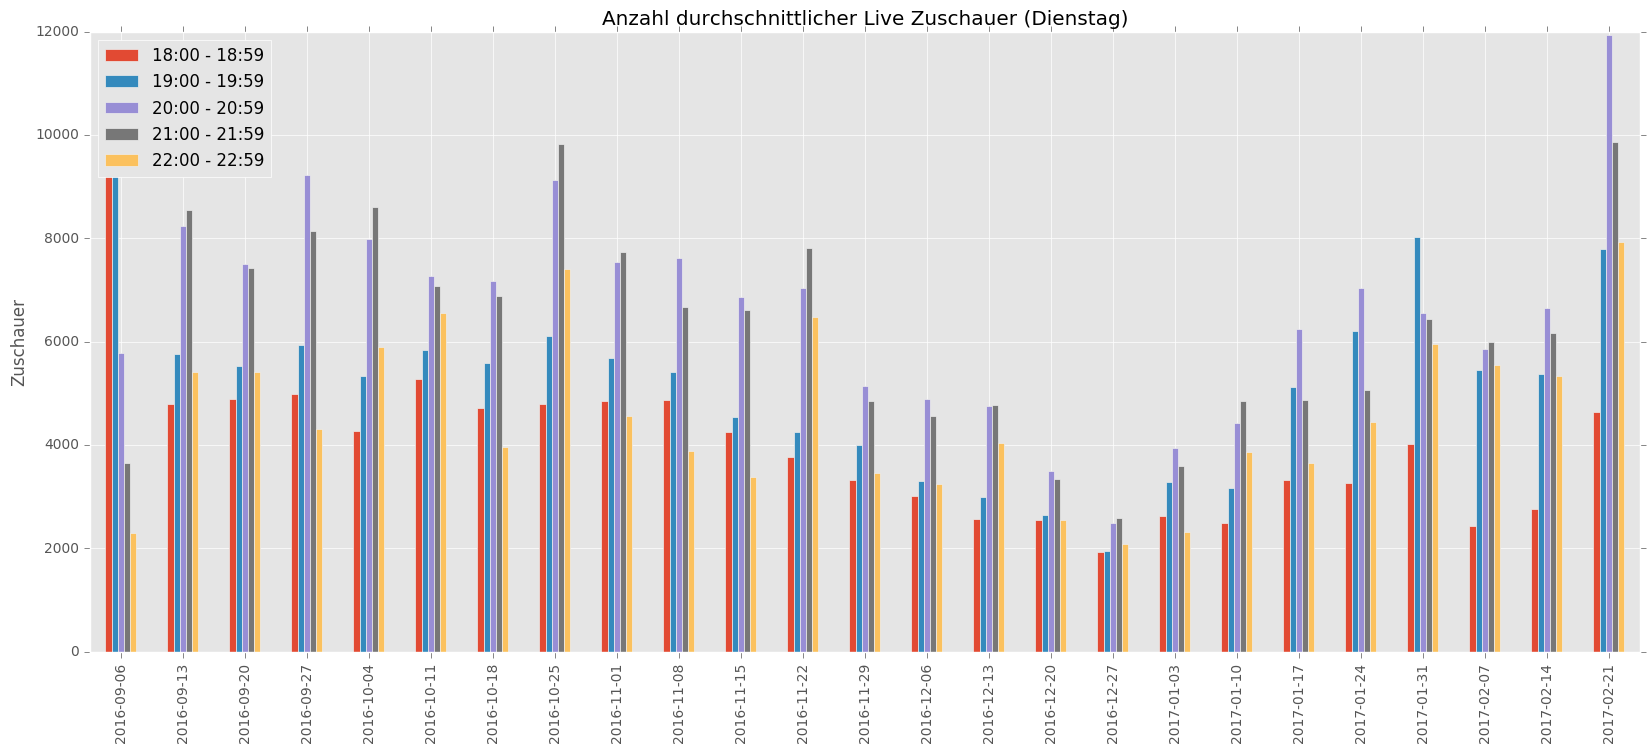

,18:00 - 18:59,19:00 - 19:59,20:00 - 20:59,21:00 - 21:59,22:00 - 22:59
day,,,,,
2016-09-07,8537.433333,8315.816667,6028.016667,4534.916667,2899.650000
2016-09-14,4709.650000,5309.316667,7032.116667,6347.083333,5167.733333
2016-09-21,4357.866667,4941.166667,6723.900000,6841.566667,5316.200000
2016-09-28,4665.966667,5481.583333,6570.950000,6105.650000,4606.566667
2016-10-05,4795.416667,5631.700000,7567.666667,8069.916667,5642.750000
2016-10-12,5117.566667,5497.333333,7314.416667,6870.966667,4824.650000
2016-10-19,4432.416667,5180.633333,6808.100000,6711.150000,4670.983333
2016-10-26,4887.716667,5747.033333,7510.233333,7757.450000,4827.166667
2016-11-02,4936.050000,5735.000000,7270.816667,7353.400000,5332.116667


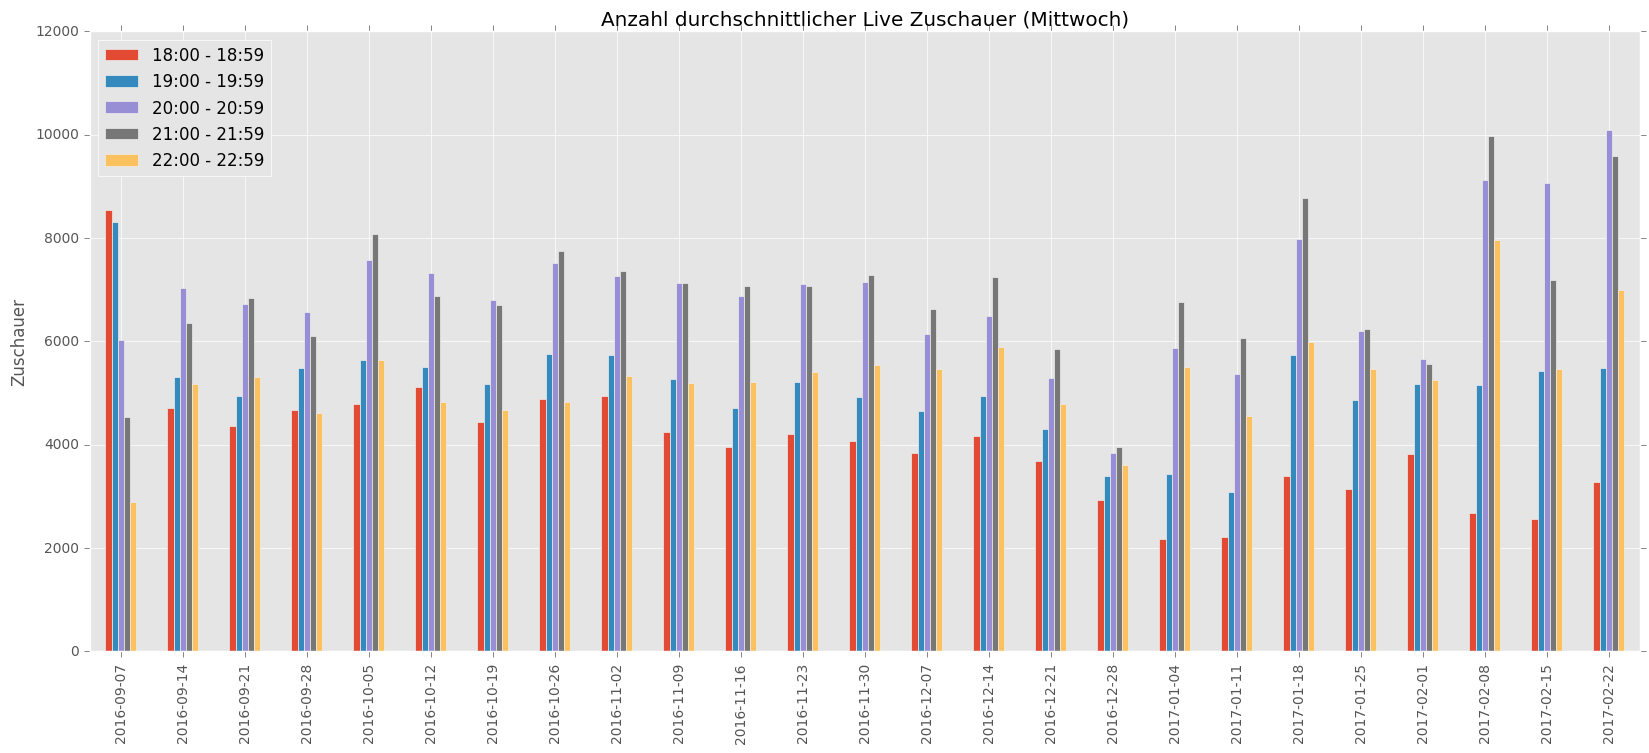

,18:00 - 18:59,19:00 - 19:59,20:00 - 20:59,21:00 - 21:59,22:00 - 22:59
day,,,,,
2016-09-01,10379.333333,11476.200000,10860.650000,6679.583333,4439.383333
2016-09-08,7376.366667,7208.500000,5706.100000,4051.433333,2405.816667
2016-09-15,5032.750000,5518.683333,6693.916667,6786.550000,5484.950000
2016-09-22,4463.383333,5204.316667,5774.100000,6066.366667,5949.066667
2016-09-29,4236.566667,4469.133333,6246.616667,6591.533333,5498.000000
2016-10-06,5118.800000,5822.916667,7664.266667,7762.433333,6010.066667
2016-10-13,5828.333333,6467.166667,7310.150000,6475.266667,5083.033333
2016-10-20,5658.650000,6070.616667,6841.066667,6864.666667,5726.316667
2016-10-27,5186.333333,5813.850000,6712.000000,6405.183333,5322.500000


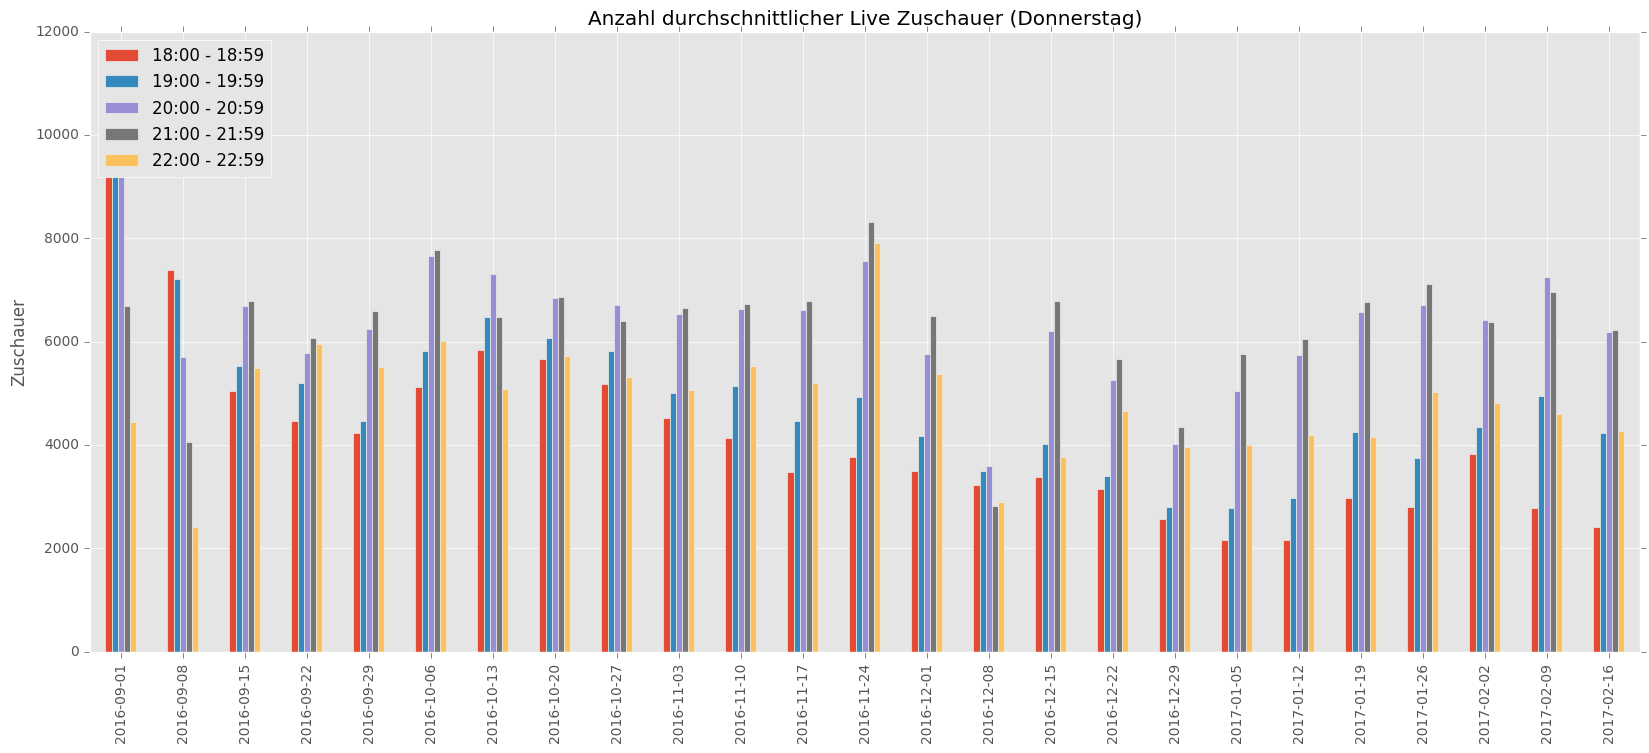

,18:00 - 18:59,19:00 - 19:59,20:00 - 20:59,21:00 - 21:59,22:00 - 22:59
day,,,,,
2016-09-02,6391.383333,5475.116667,4848.266667,3882.666667,2928.200000
2016-09-09,NaN,NaN,NaN,NaN,3373.250000
2016-09-16,4913.366667,4822.216667,5887.716667,5923.000000,5943.416667
2016-09-23,3763.650000,3361.683333,3448.483333,3348.516667,3058.750000
2016-09-30,4249.766667,3806.533333,3623.100000,3156.583333,2950.666667
2016-10-07,6211.383333,14596.816667,24296.583333,24600.683333,23061.183333
2016-10-14,3830.466667,3898.716667,3576.616667,3146.100000,2712.483333
2016-10-21,3894.533333,3658.583333,3673.800000,3346.200000,3740.766667
2016-10-28,5252.583333,5213.533333,5949.166667,6075.683333,6167.466667


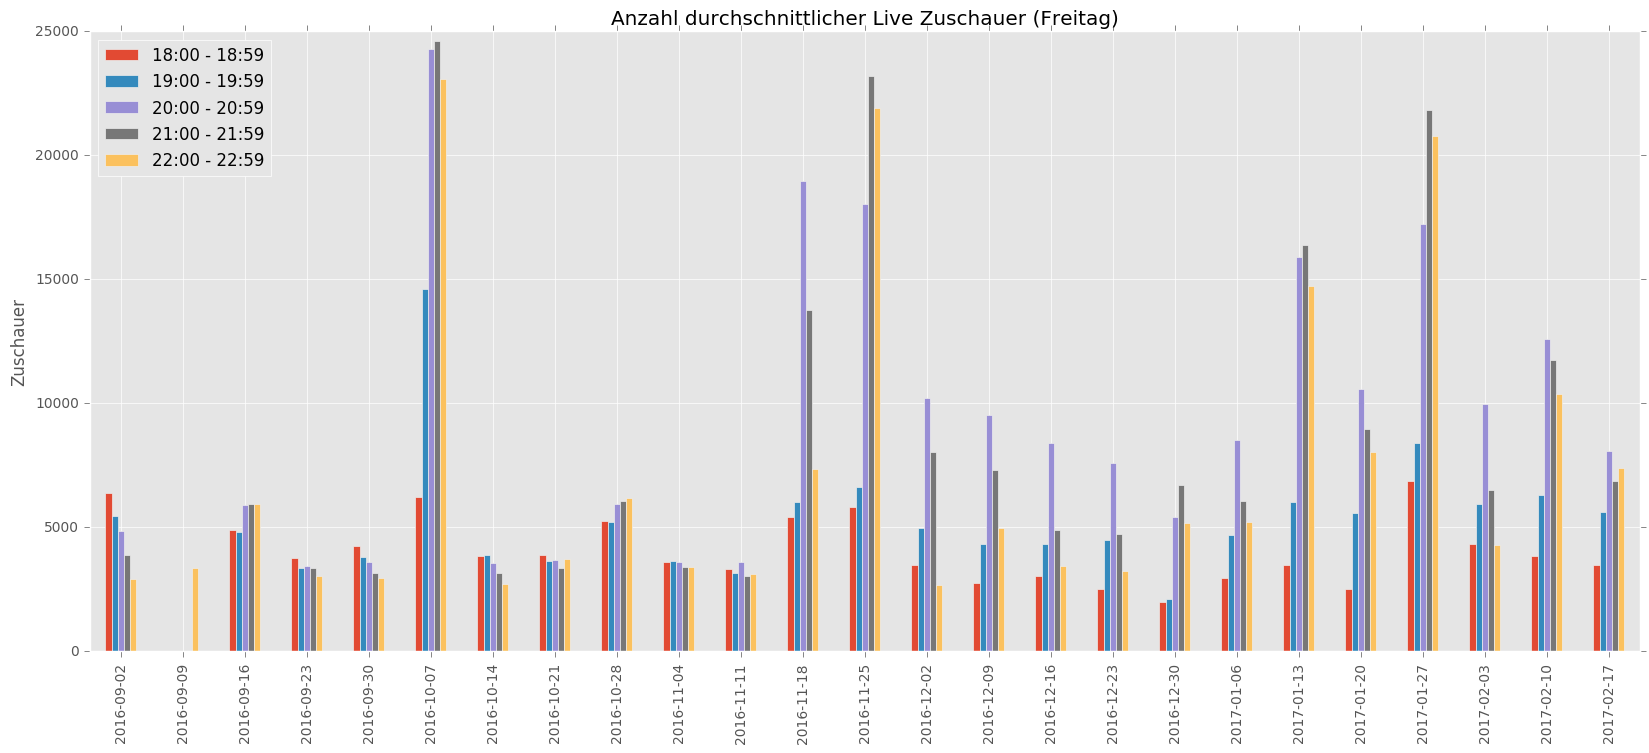

,18:00 - 18:59,19:00 - 19:59,20:00 - 20:59,21:00 - 21:59,22:00 - 22:59
day,,,,,
2016-09-03,3059.200000,2837.816667,2225.733333,2141.733333,2043.916667
2016-09-10,2071.766667,2250.616667,2348.600000,2322.533333,2324.883333
2016-09-17,2107.966667,2718.716667,2677.100000,2387.583333,2299.683333
2016-09-24,1863.483333,2302.416667,2393.733333,2472.450000,2371.150000
2016-10-01,1778.300000,2001.400000,2180.150000,2072.350000,2117.150000
2016-10-08,1715.600000,2102.283333,2109.550000,1970.950000,1946.483333
2016-10-15,1957.333333,2330.333333,2223.833333,2193.216667,1993.816667
2016-10-22,1747.033333,2223.083333,2157.533333,2071.100000,1666.683333
2016-10-29,1988.450000,2130.816667,2096.500000,2130.533333,2178.783333


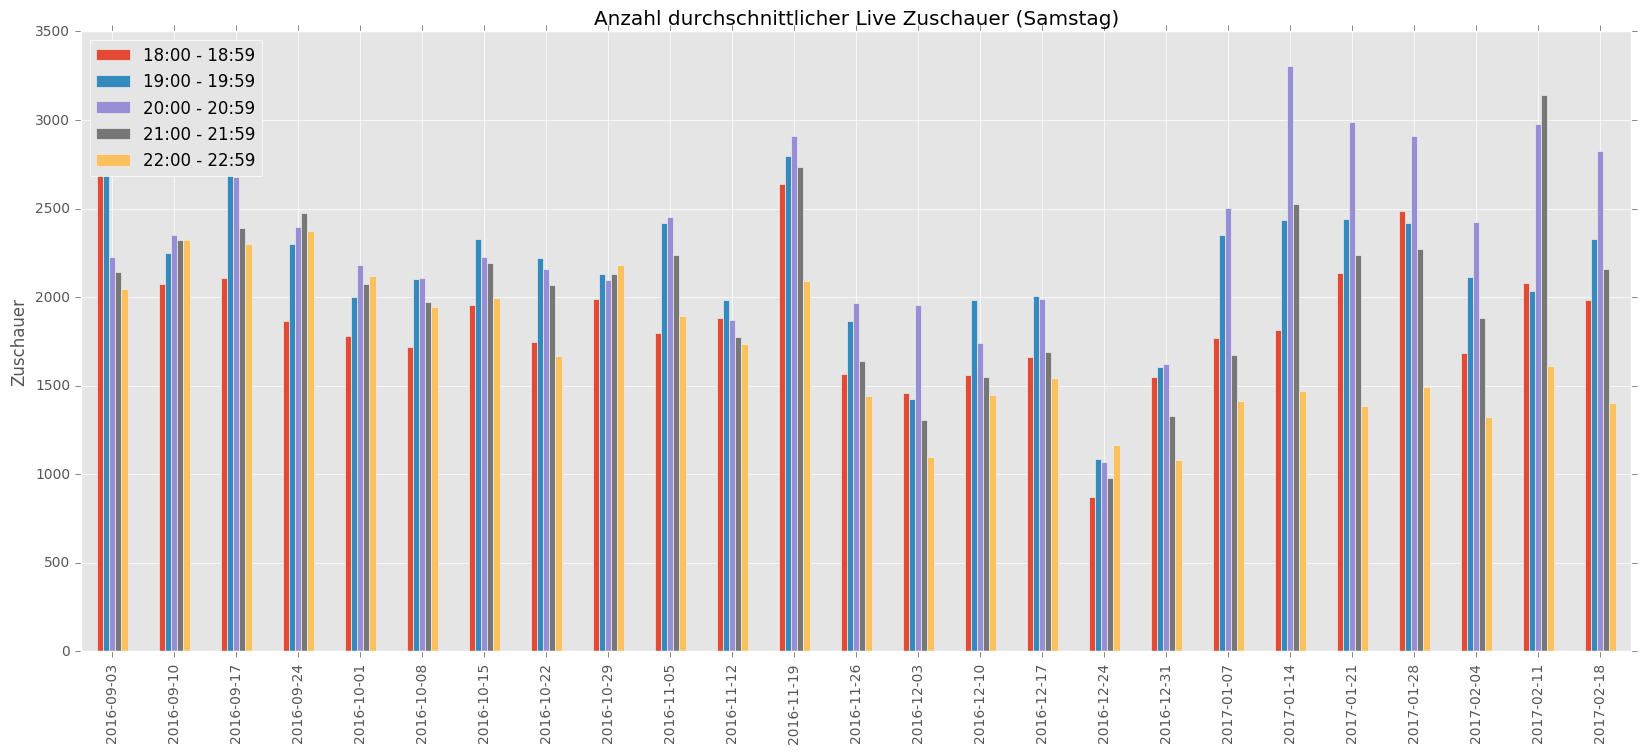

,18:00 - 18:59,19:00 - 19:59,20:00 - 20:59,21:00 - 21:59,22:00 - 22:59
day,,,,,
2016-09-04,4775.300000,3976.516667,3195.750000,2352.733333,1700.016667
2016-09-11,2312.300000,2674.150000,4239.133333,3949.016667,3032.850000
2016-09-18,2299.000000,2521.450000,3967.866667,3776.833333,2605.683333
2016-09-25,2107.400000,2557.883333,4919.850000,4955.016667,2092.016667
2016-10-02,1662.300000,1867.050000,2837.700000,2821.300000,2076.833333
2016-10-09,2534.400000,2346.250000,3361.483333,3251.216667,2109.483333
2016-10-16,2091.600000,2336.466667,3845.166667,4044.516667,2622.733333
2016-10-23,1939.916667,2199.583333,3404.283333,3034.650000,2272.500000
2016-10-30,3404.150000,3708.000000,5384.216667,5674.366667,4763.450000


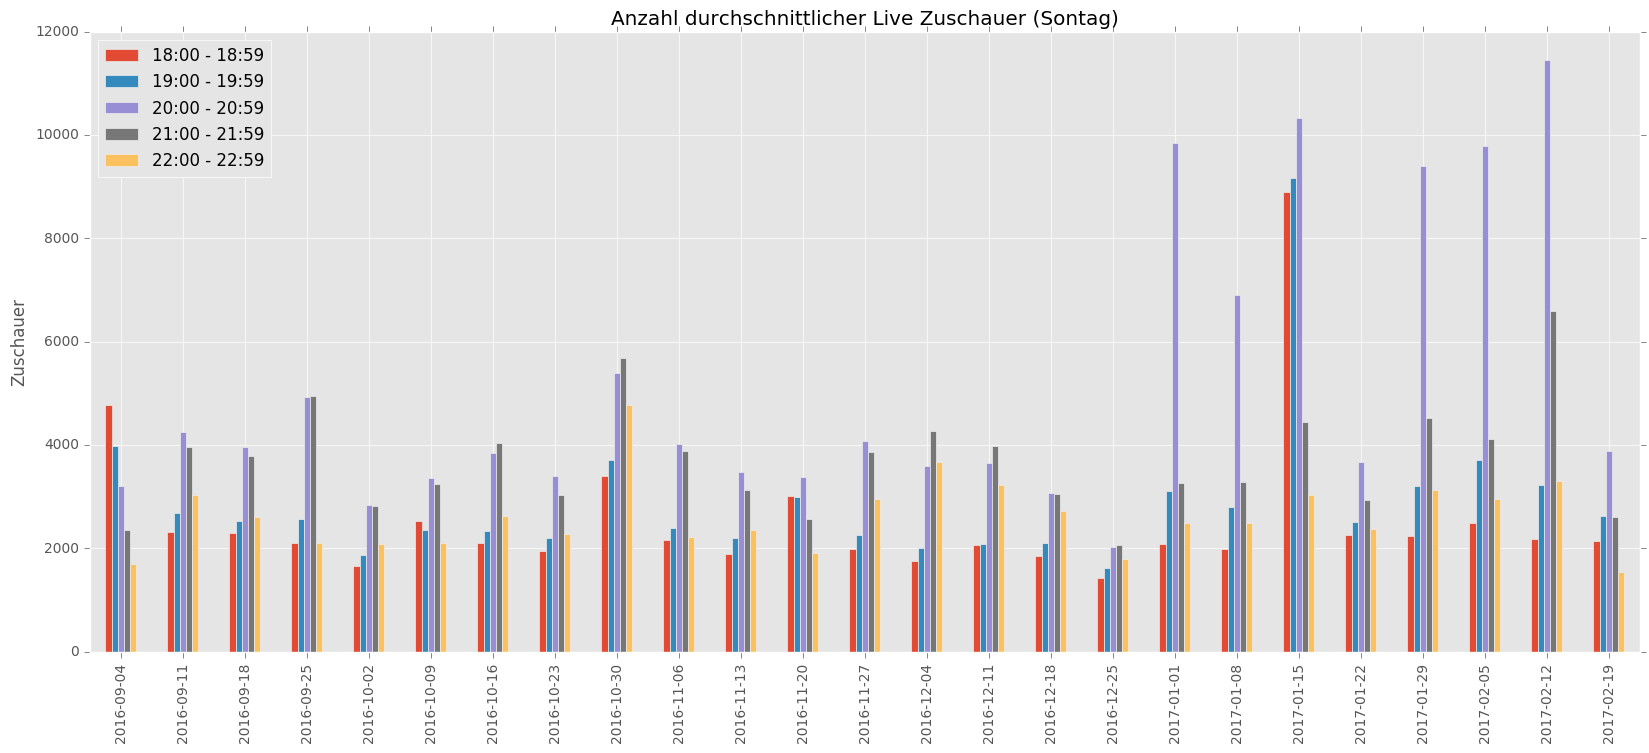

In [4]:
#filter data by date
start = datetime.datetime(2016, 9, 1)
end = datetime.datetime.now()
liveFiltered = live.loc[start : end]

weekdayNames = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sontag']

dataMonthly = []
for i in range(0, 7):
    #filter data by weekday
    liveFilteredWeekday = liveFiltered[liveFiltered['weekday'] == i]
    
    dataMonthly.append({})

    #filter data by time
    rangeStart = datetime.time(18, 0, 0)
    rangeEnd = datetime.time(18, 59, 59)
    until = datetime.time(0, 0, 0)
    data = pd.DataFrame({})
    for j in range(0, 5):
        rangeStr = rangeStart.strftime('%H:%M') + ' - ' + rangeEnd.strftime('%H:%M')

        dataMonthly[i][rangeStr] = pd.DataFrame()

        #filter data by time
        liveFilteredTime = liveFilteredWeekday.between_time(rangeStart, rangeEnd)

        #group messages by date
        liveGrouped = liveFilteredTime.groupby('day')

        #filter groups by minimum number of datapoints
        liveGrouped = liveGrouped.filter(lambda group: len(group) > 25)

        #group messages by date
        liveGrouped = liveGrouped.groupby('day')

        #calculate mean for each day
        liveMean = liveGrouped.apply(lambda group: group['viewers'].mean())

        data[rangeStr] = liveMean
        
        #group monthly
        liveMean = liveMean.to_frame('viewers')
        liveMean = liveMean.set_index(pd.to_datetime(liveMean.index, format='%Y-%m-%d'))
        liveGrouped = liveMean.groupby(liveMean.index.strftime('%Y-%m'))
        
        #add monthly data
        for group, dataMonth in liveGrouped:
            dataMonth = dataMonth['viewers'].tolist()
            dataMonth += [float('NaN')] * (5 - len(dataMonth))
            dataMonthly[i][rangeStr][group] = dataMonth

        #add 2 hours
        rangeStart = (datetime.datetime.combine(datetime.date.today(), rangeStart) + datetime.timedelta(hours=1)).time()
        rangeEnd = (datetime.datetime.combine(datetime.date.today(), rangeEnd) + datetime.timedelta(hours=1)).time()

    display(data)

    #plot
    plot = data.plot(kind='bar', figsize=(20, 8), title='Anzahl durchschnittlicher Live Zuschauer (%s)' % weekdayNames[i])
    plot.set_xlabel('')
    plot.set_ylabel('Zuschauer')

    legend = plot.legend(loc=2)

    plt.ylim(ymin=0)
    plt.show()

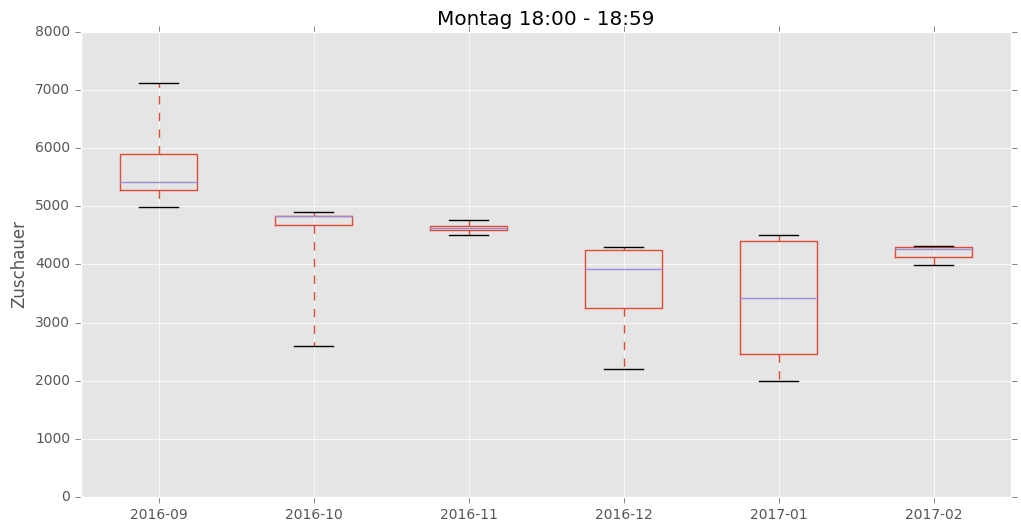

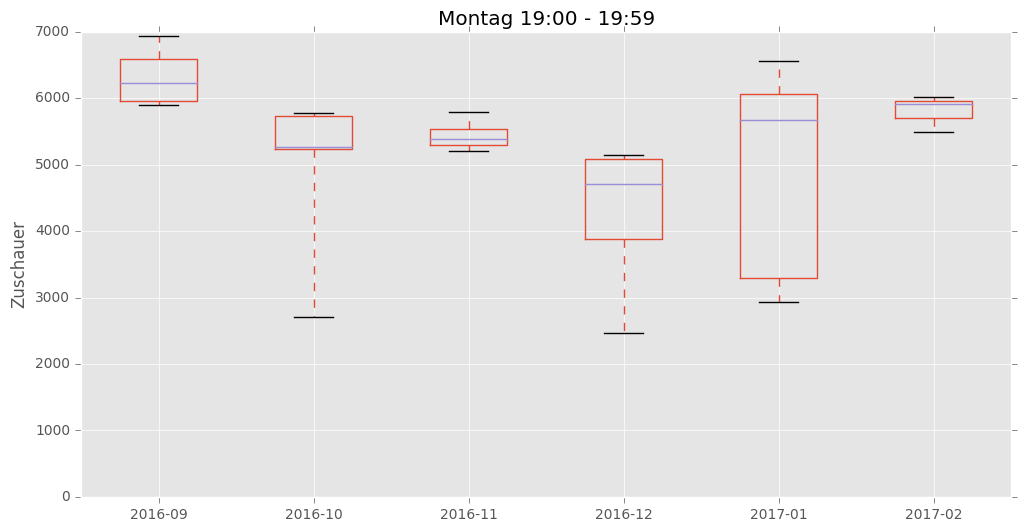

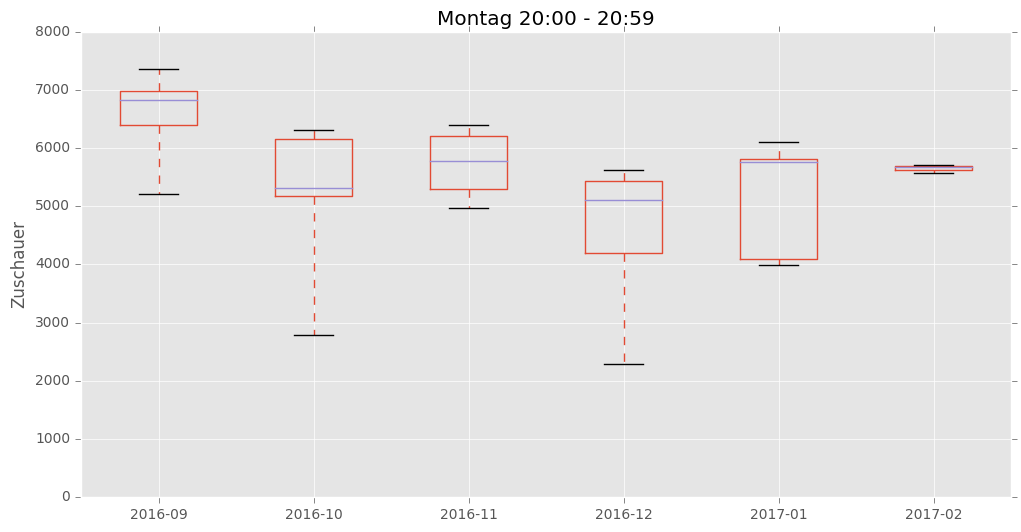

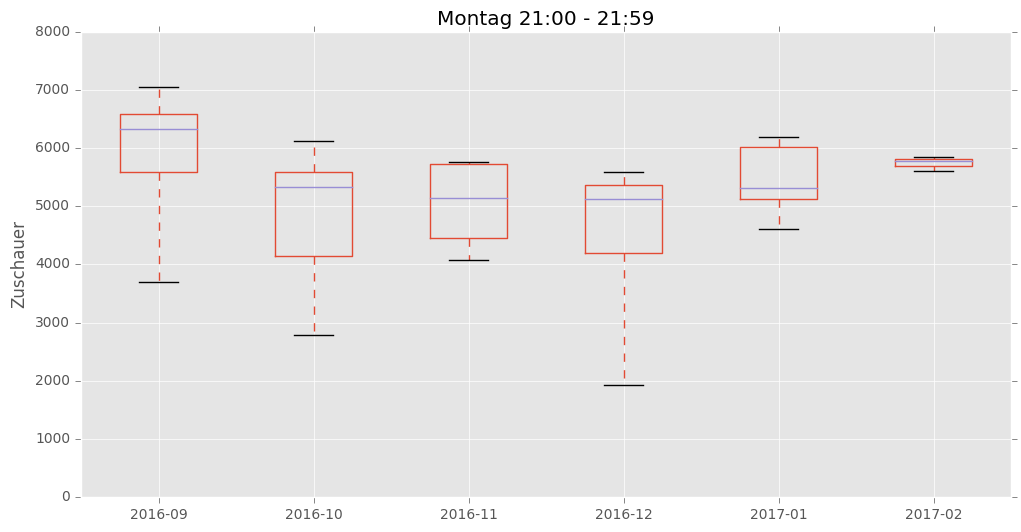

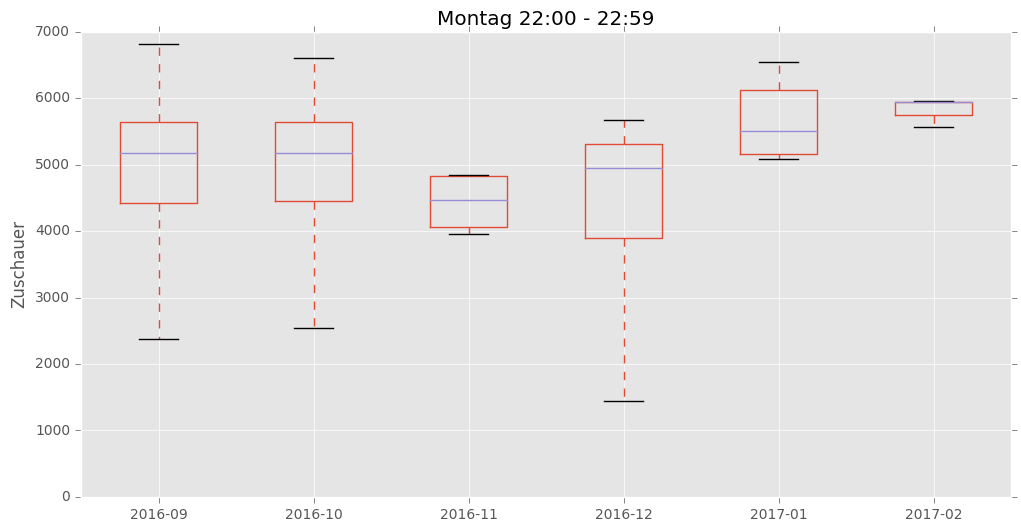

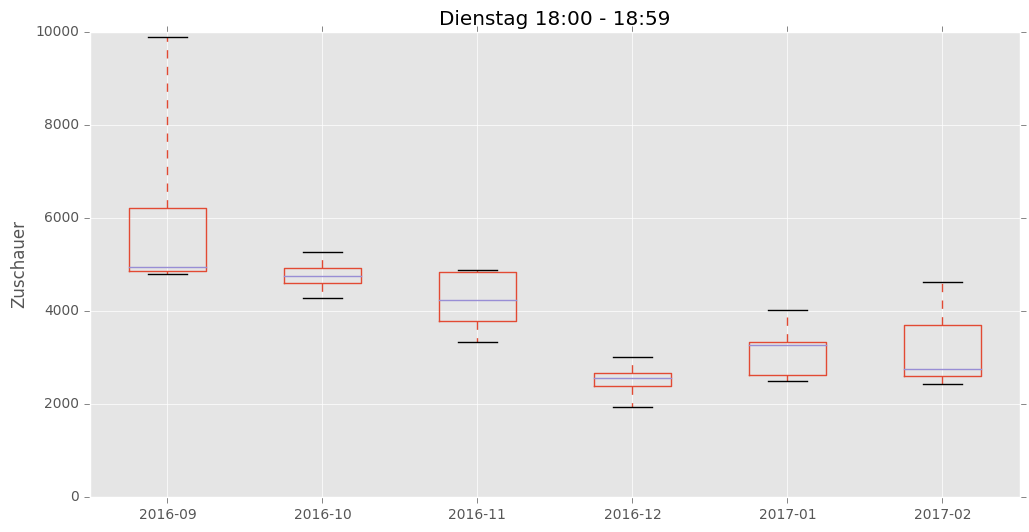

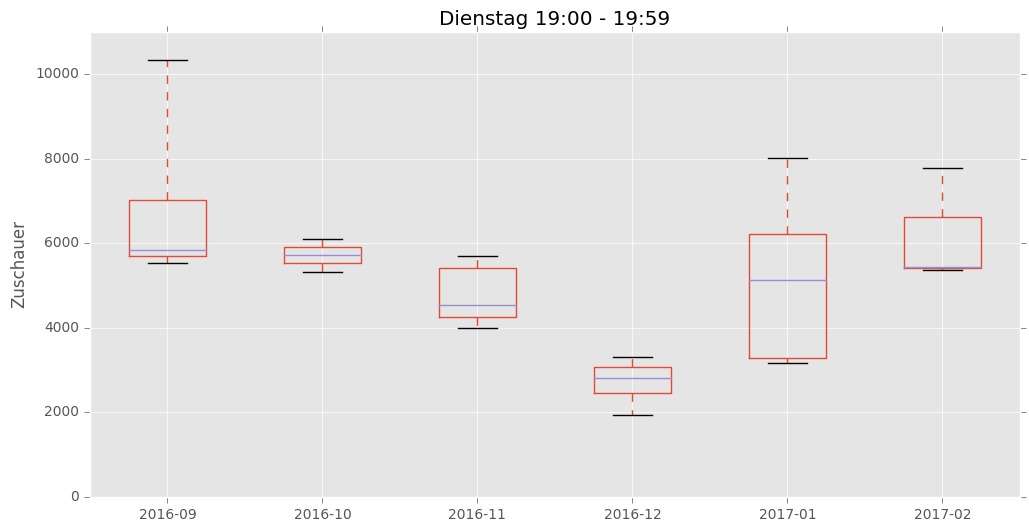

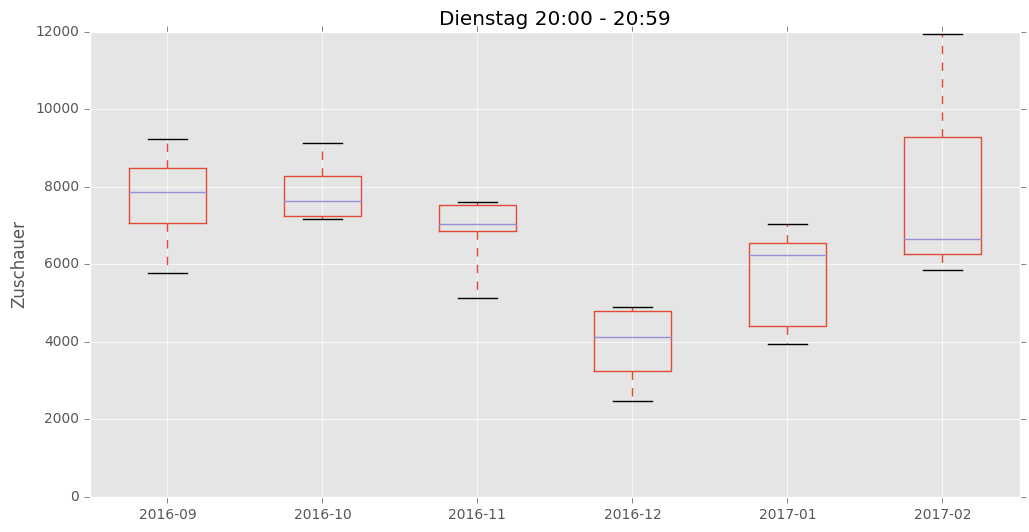

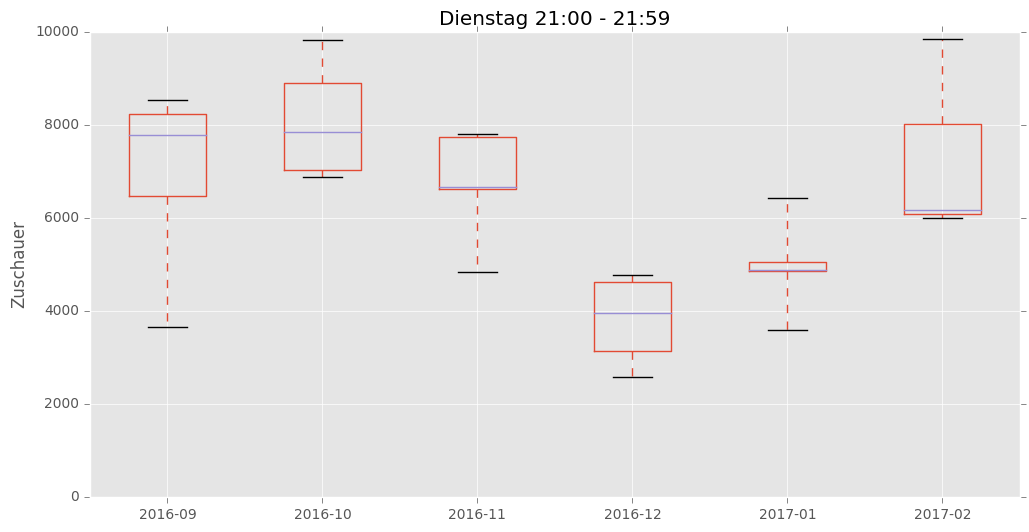

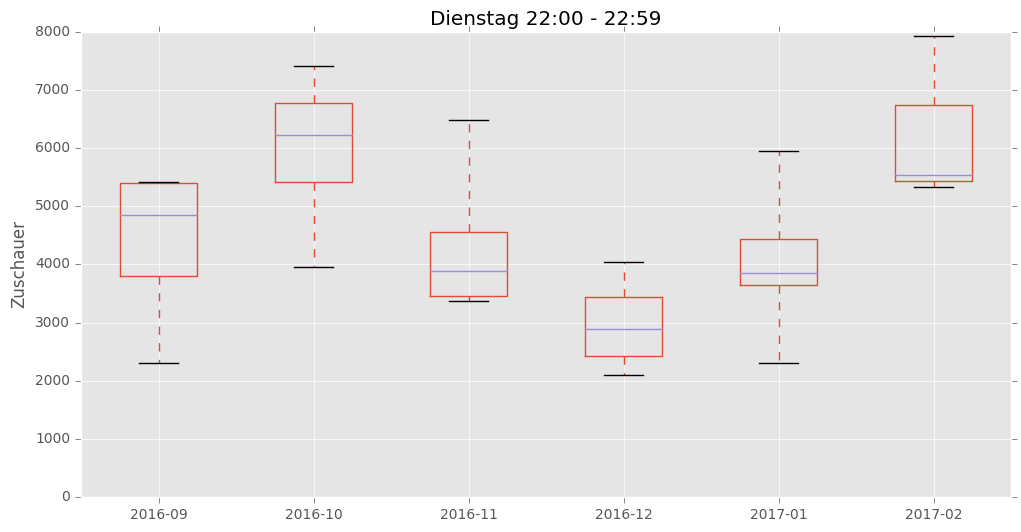

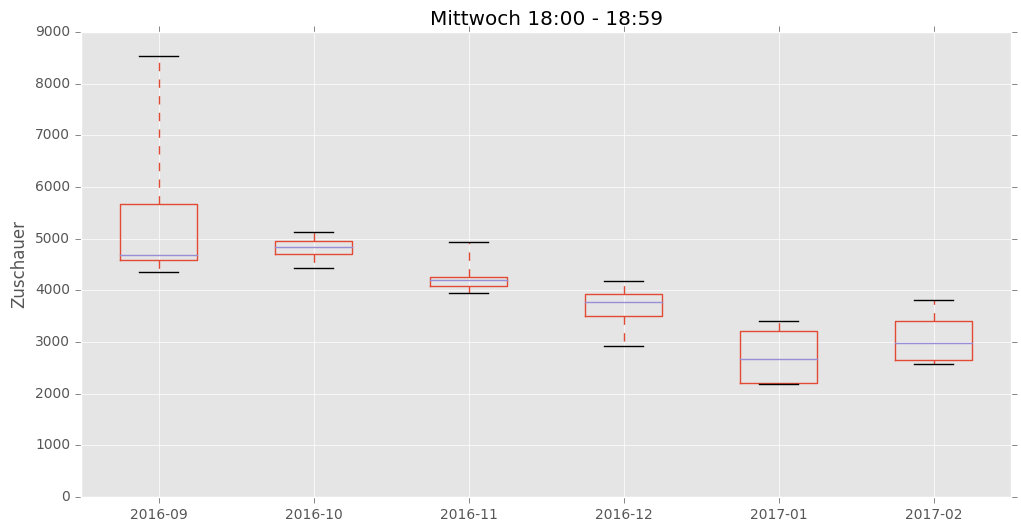

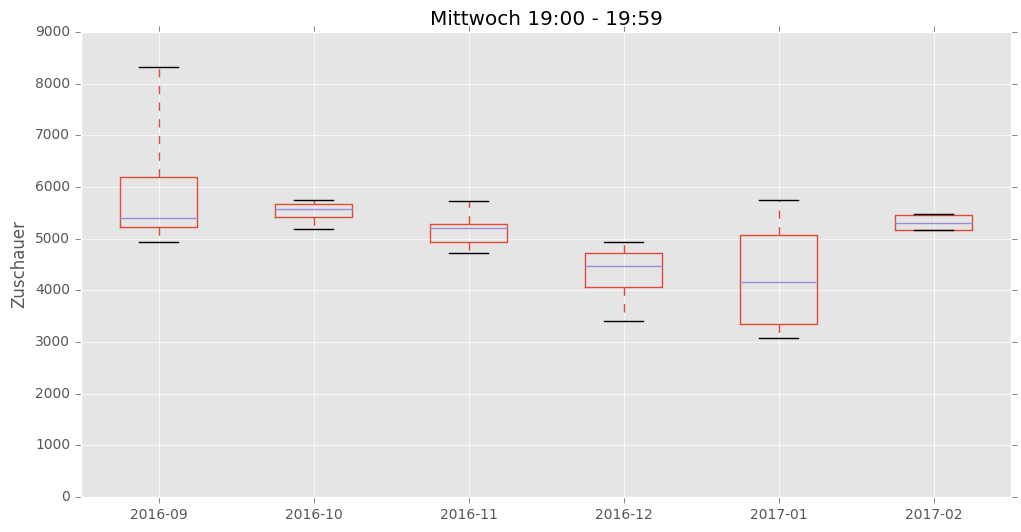

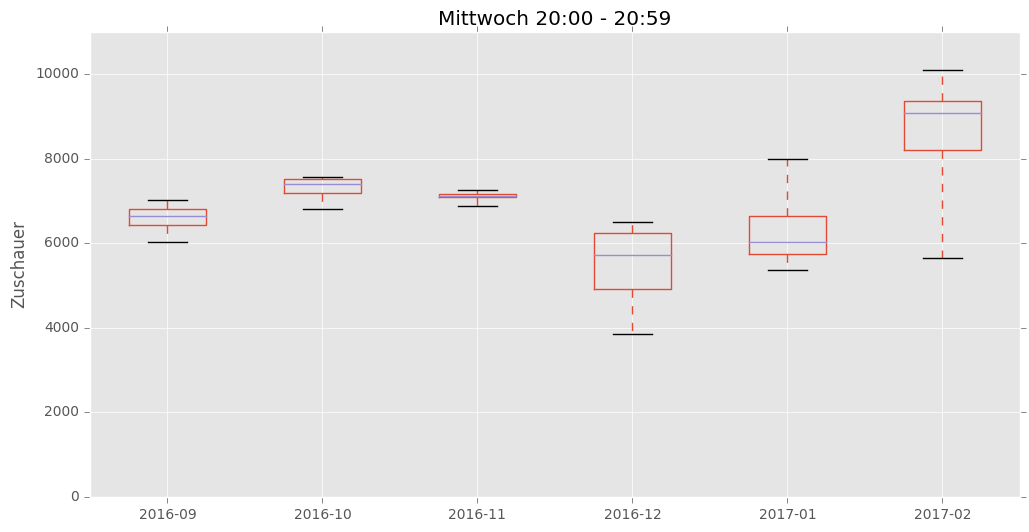

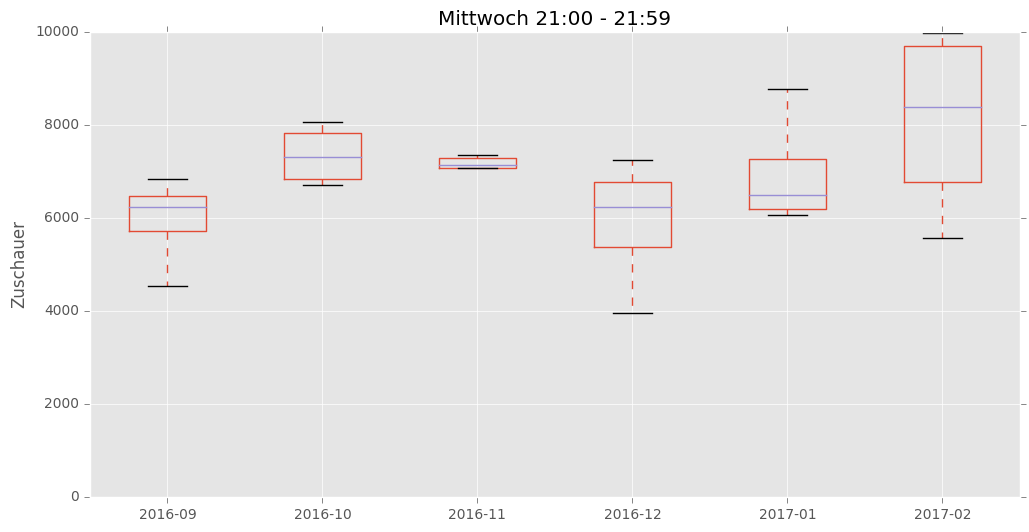

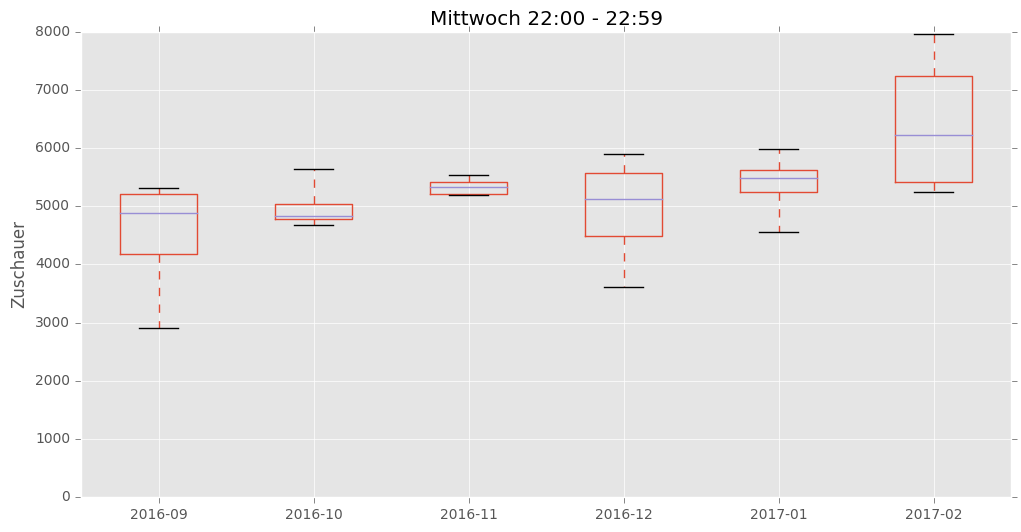

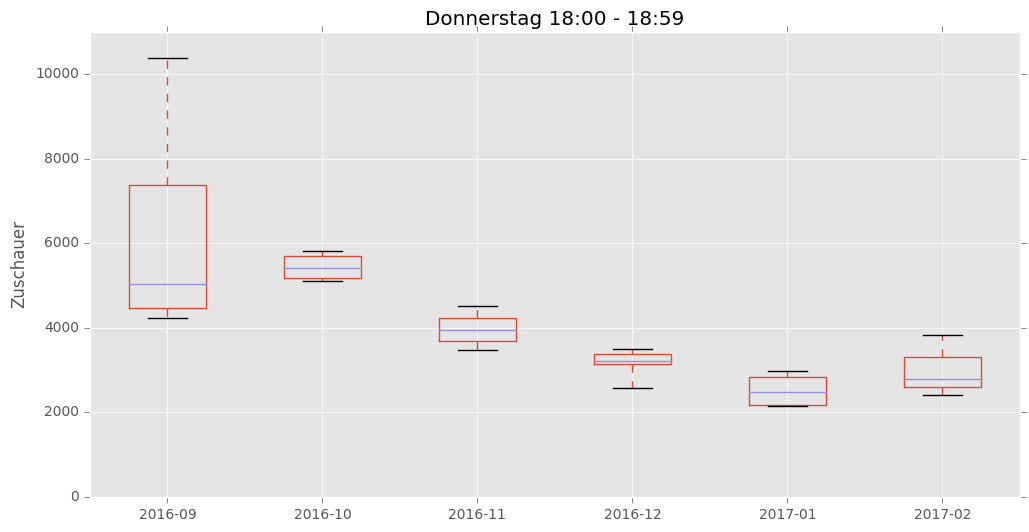

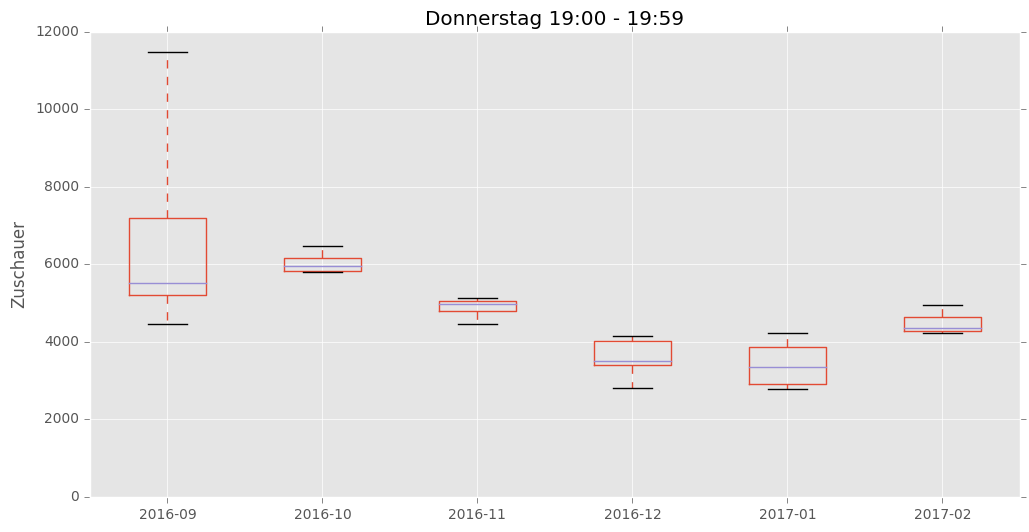

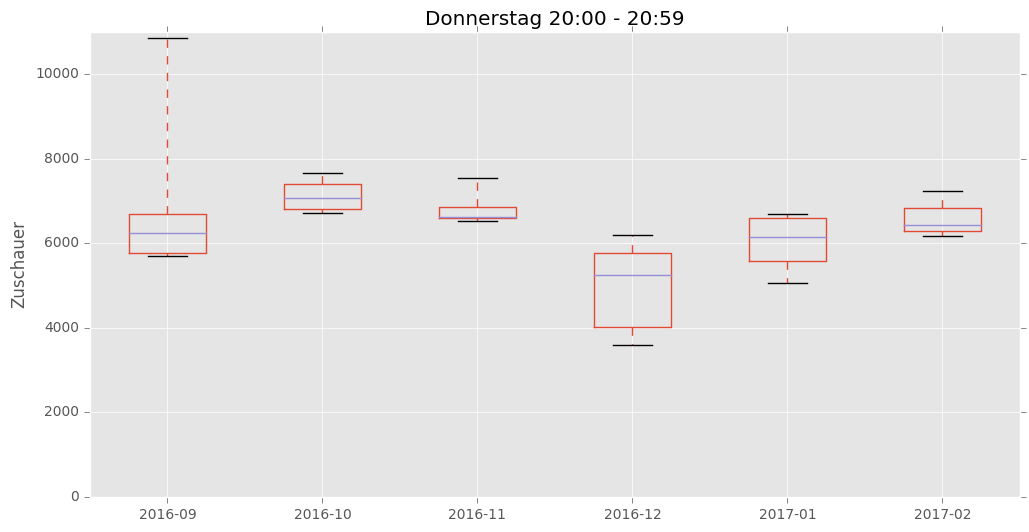

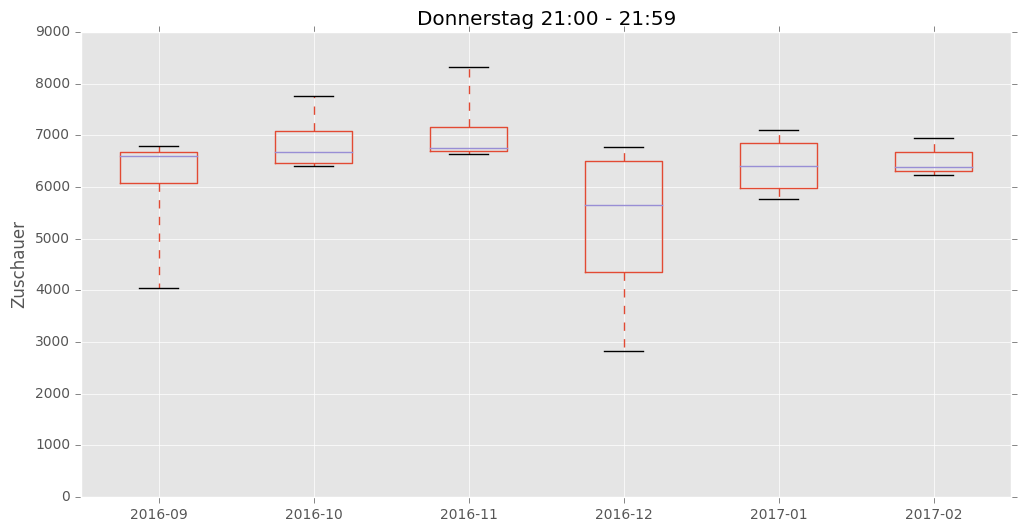

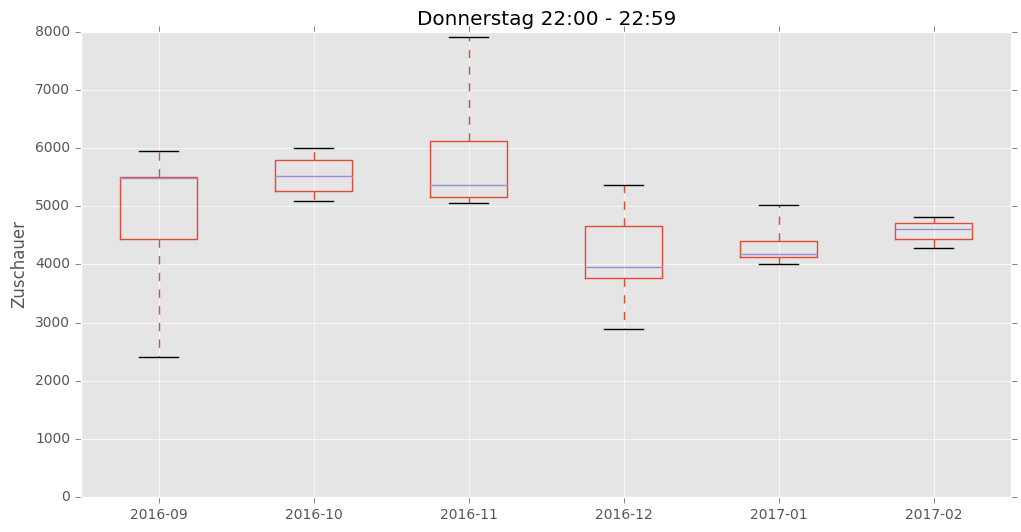

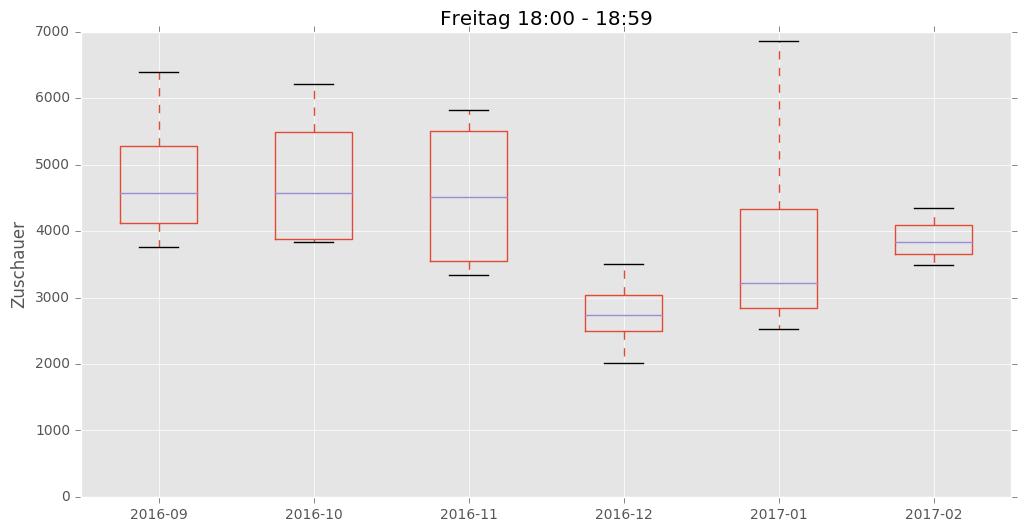

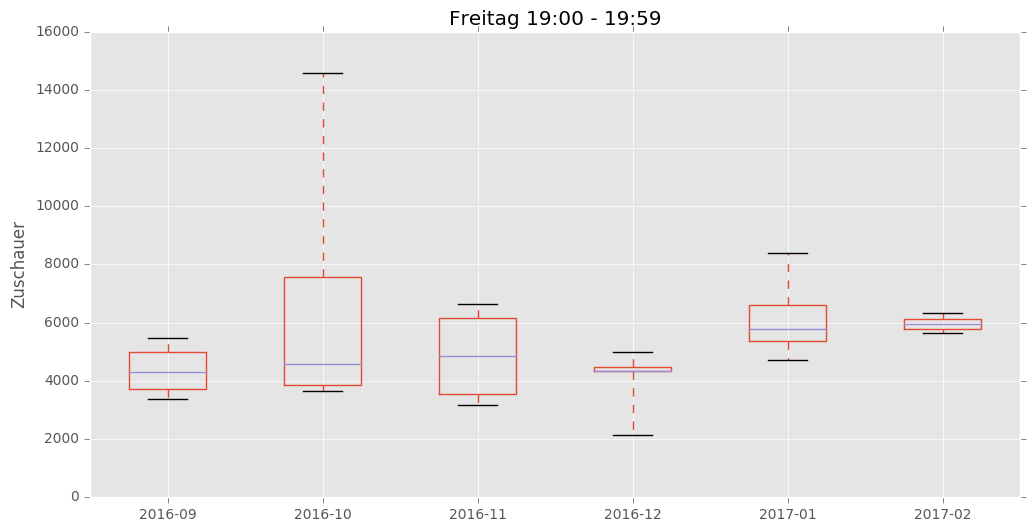

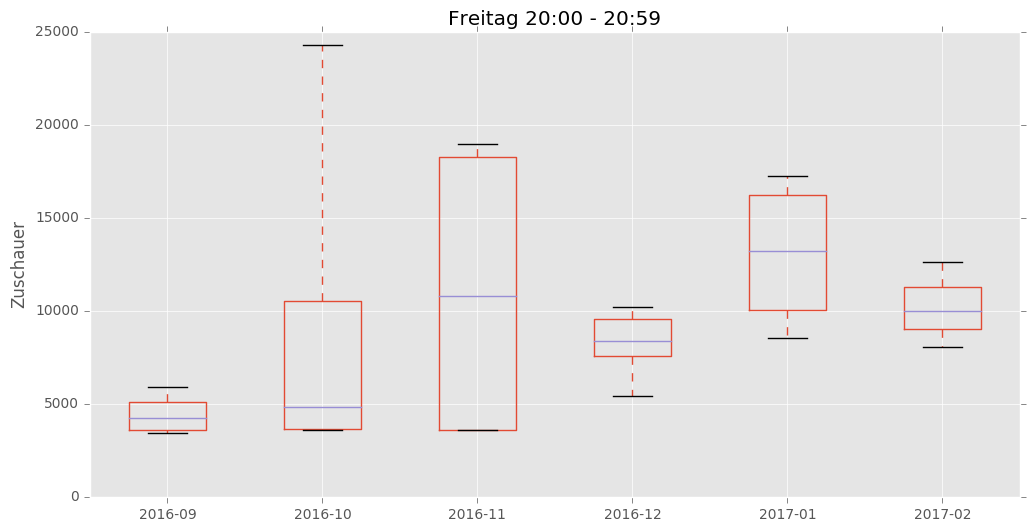

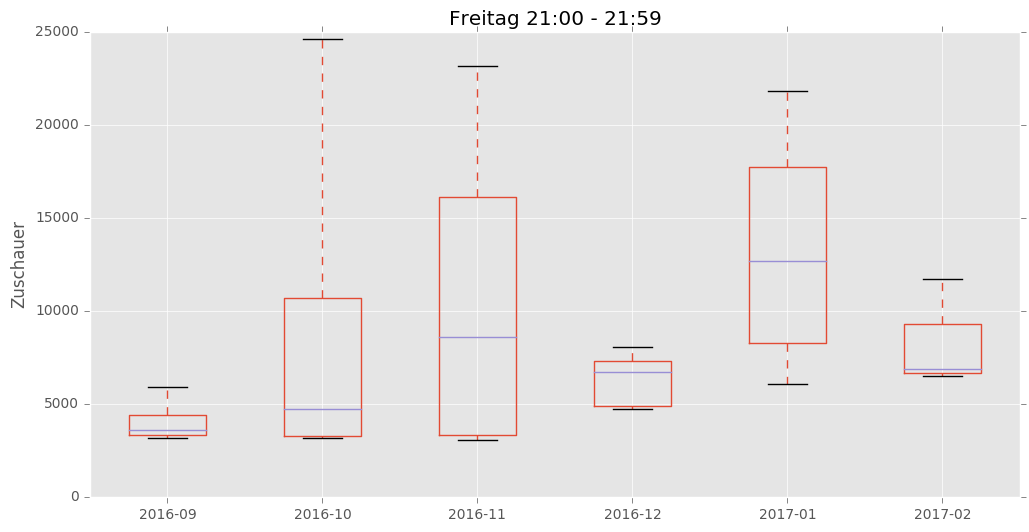

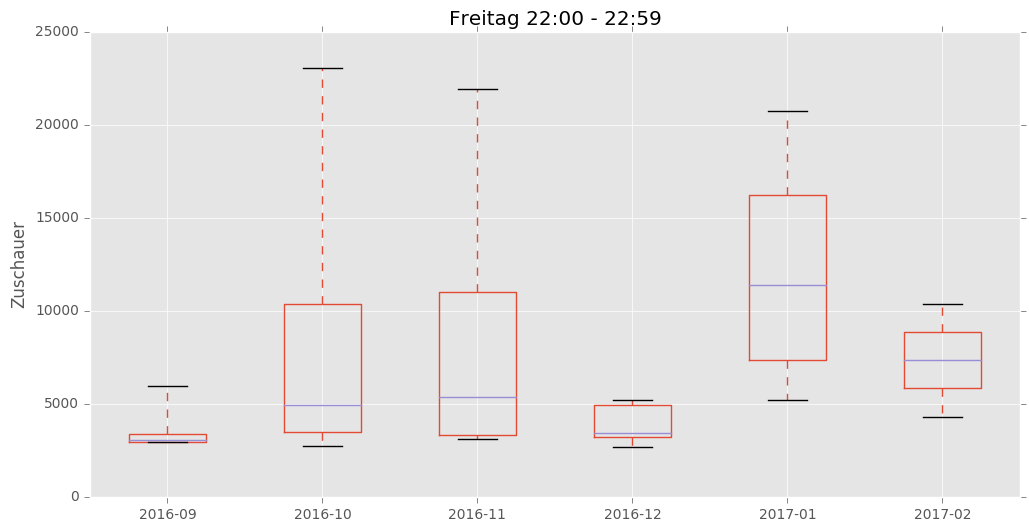

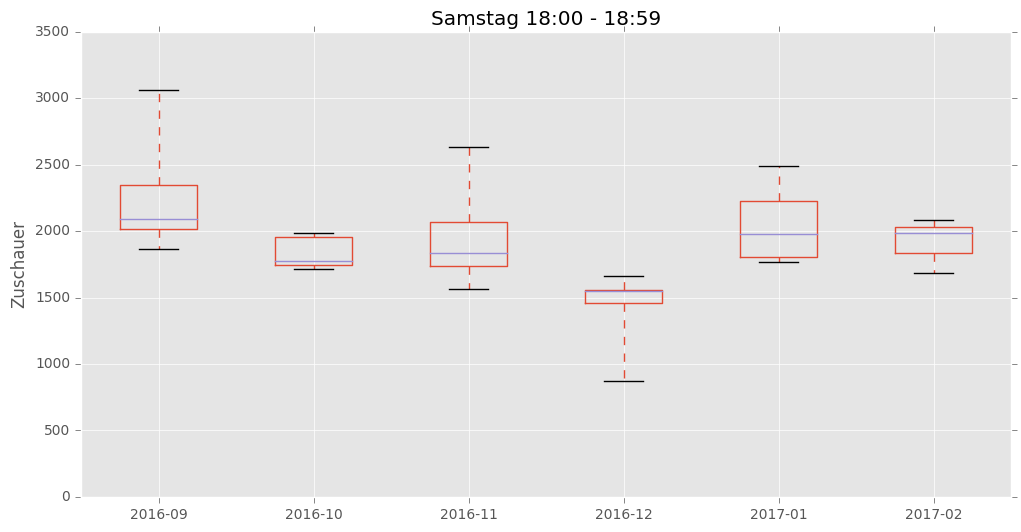

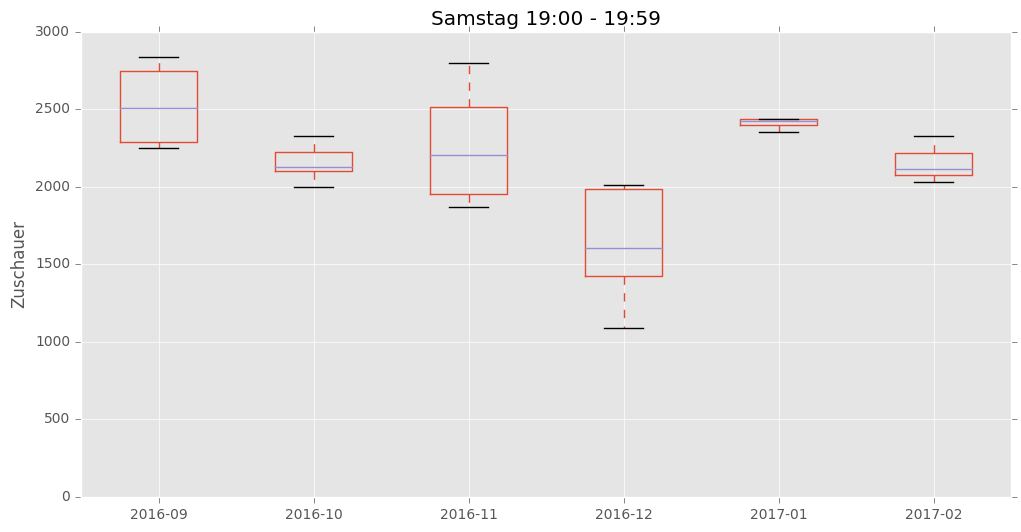

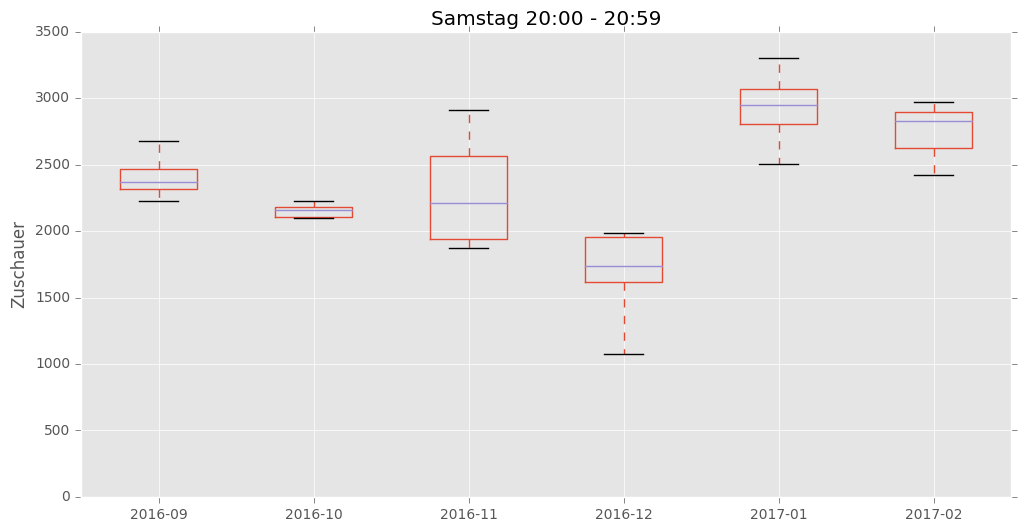

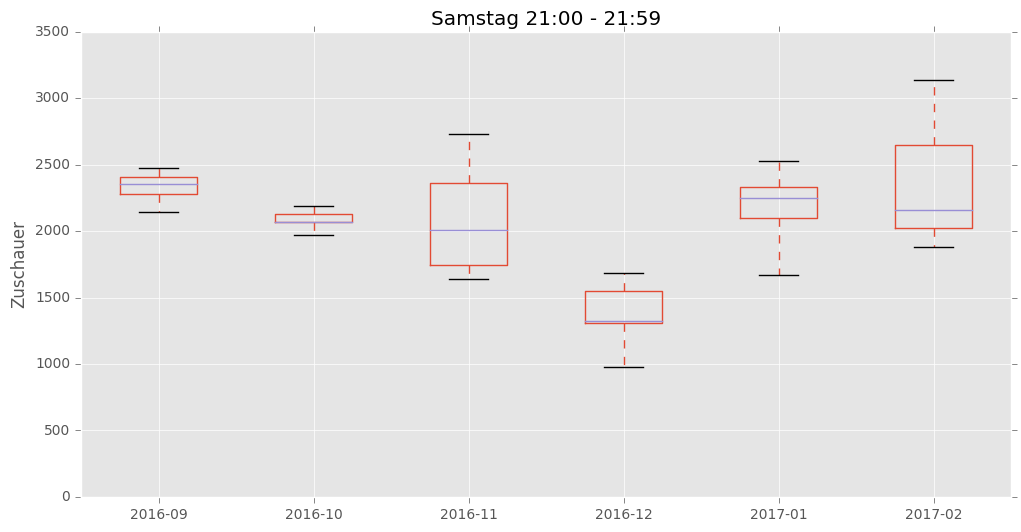

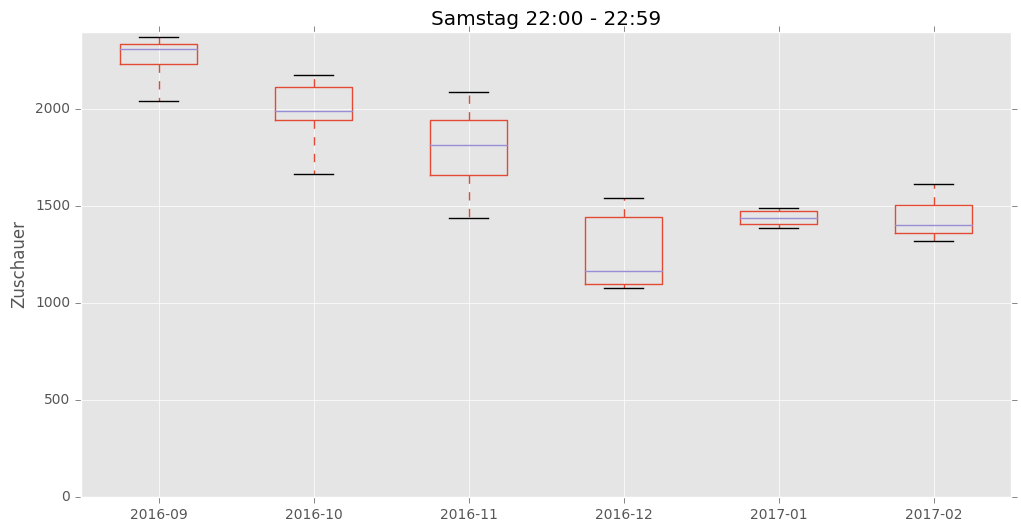

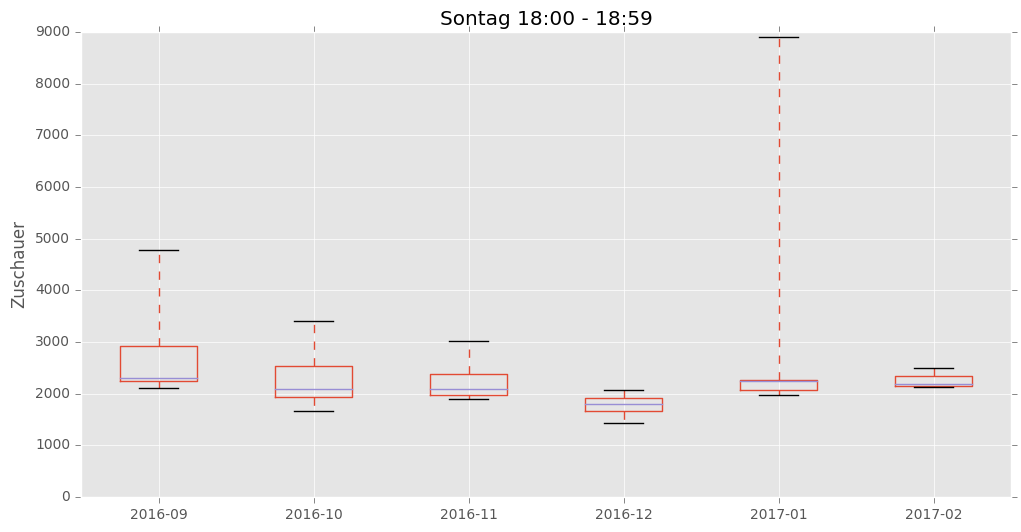

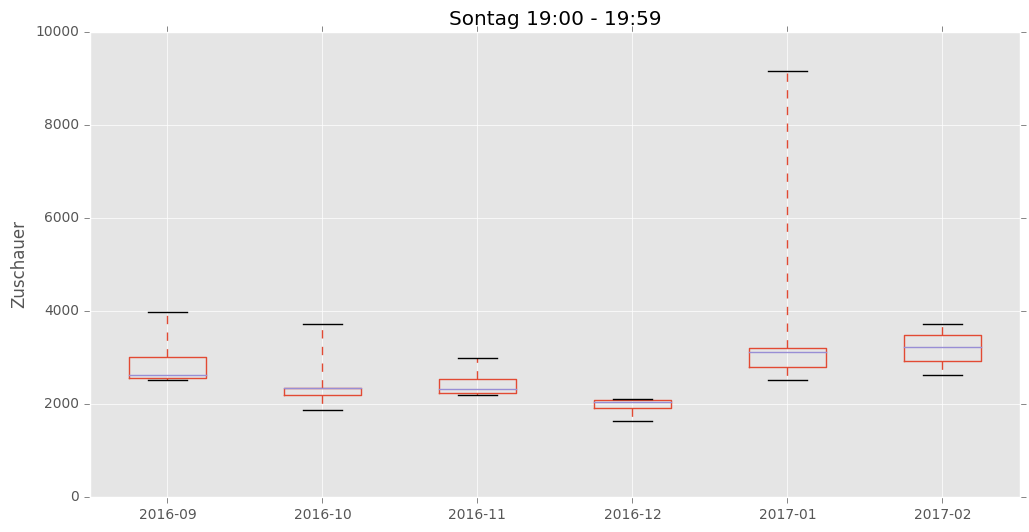

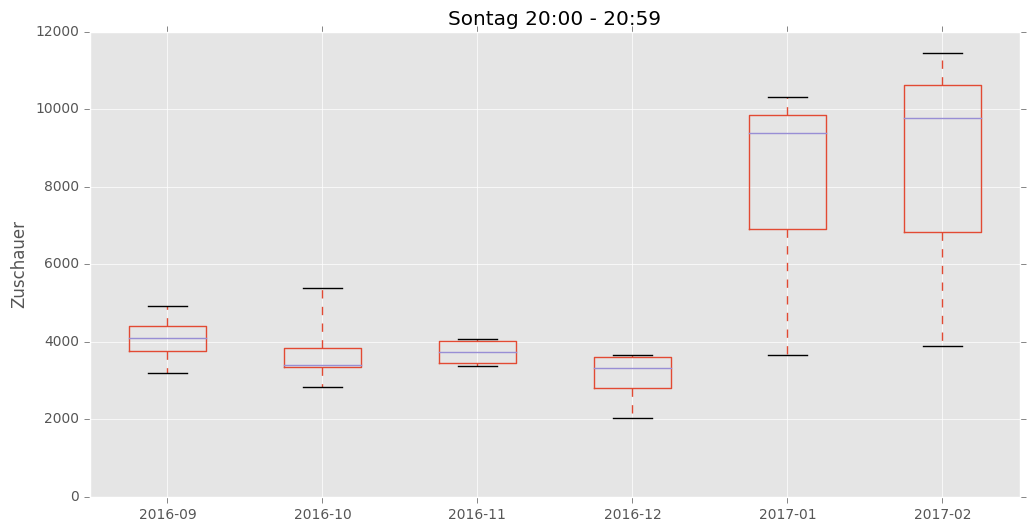

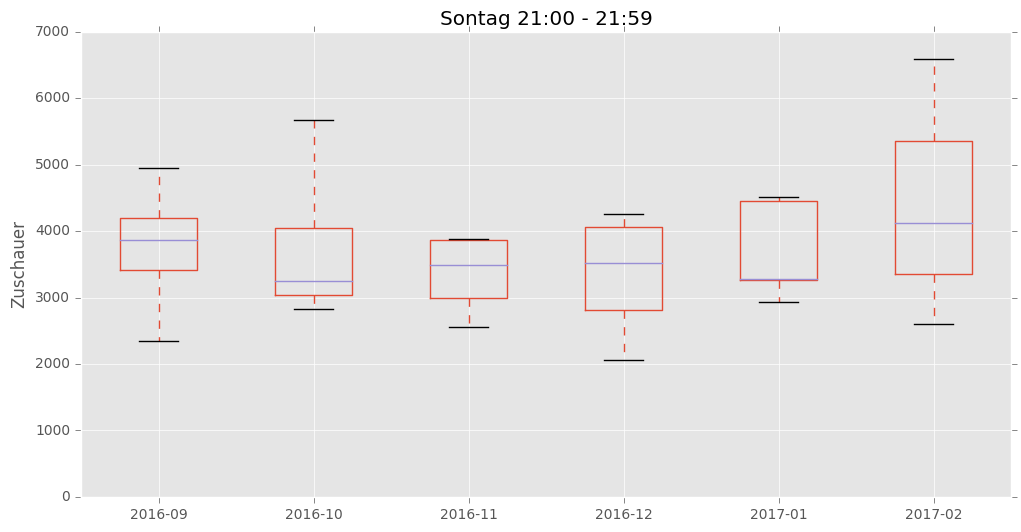

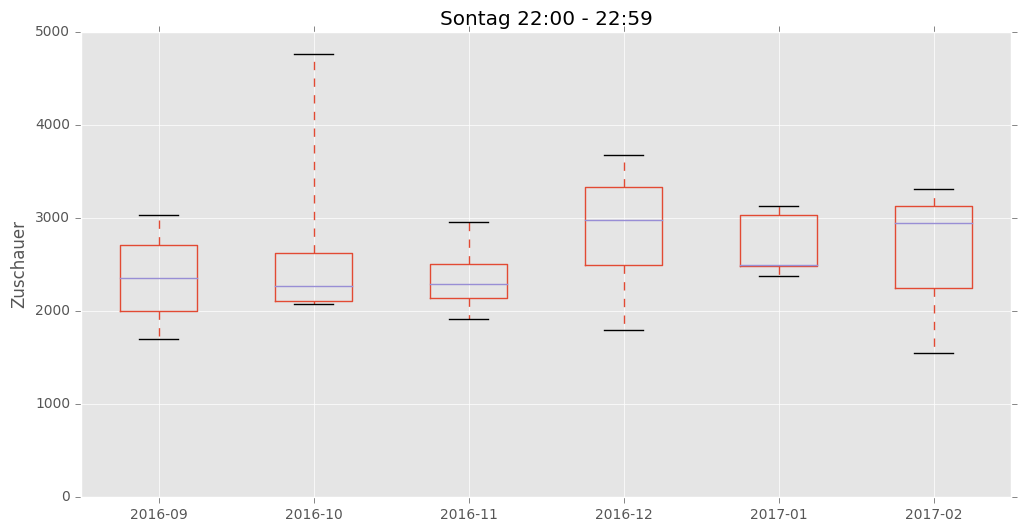

In [5]:
for i, value in enumerate(dataMonthly):
    weekdayStr = weekdayNames[i]
    for timeStr, data in sorted(value.iteritems()):
        plot = data.plot(kind='box', figsize=(12, 6), title='%s %s' % (weekdayStr, timeStr), whis=100)
        plot.set_ylabel('Zuschauer')
        plt.ylim(ymin=0)